<a href="https://colab.research.google.com/github/BalthazazarDuc/MasterThesis/blob/main/Copie_de_MasterThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [171]:
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import geopandas as gpd
import numpy as np
import random
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [172]:
#GO_price = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/GO-Prices_Aggregated_v02%20.csv", sep=";", decimal = ",")
carbon_intensity = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/carbon-intensity-electricity.csv")
CI_PV = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/carbon_intensity_rooftop.csv")
LCOE = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/LCOE%202020.csv", sep=";")
solar_yield = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/solar_yield.csv")
E_price = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/european_wholesale_electricity_price_data_monthly.csv")


#We use the last one that come from Amber website

##Data cleaning

###carbon_intensity

In [173]:
german_to_english = {
    "Belgien": "Belgium",
    "D√§nemark": "Denmark",
    "Deutschland": "Germany",
    "Estland": "Estonia",
    "Finnland": "Finland",
    "Frankreich": "France",
    "Griechenland": "Greece",
    "Irland": "Ireland",
    "Island": "Iceland",
    "Italien": "Italy",
    "Kroatien": "Croatia",
    "Litauen": "Lithuania",
    "Luxemburg": "Luxembourg",
    "Niederlande": "Netherlands",
    "Norwegen": "Norway",
    "√ñsterreich": "Austria",
    "Portugal": "Portugal",
    "Schweden": "Sweden",
    "Schweiz": "Switzerland",
    "Serbien": "Serbia",
    "Slowakei": "Slovakia",
    "Slowenien": "Slovenia",
    "Spanien": "Spain",
    "Tschechien": "Czech Republic",
    "Zypern": "Cyprus",
    "(Leer)": "Unknown"  # or you can use None or drop it depending on your case
}
# Step 1: Use the English country names from the dictionary
english_country_names = list(german_to_english.values())

# Step 2: Filter the carbon_intensity DataFrame
carbon_intensity = carbon_intensity[carbon_intensity['Entity'].isin(english_country_names)]
carbon_intensity = carbon_intensity.rename(columns={'Entity': 'Country'})
carbon_intensity

Country Code  Year  Carbon intensity of electricity - gCO2/kWh
350       Austria  AUT  1990                                  249.847780
351       Austria  AUT  1991                                  262.759200
352       Austria  AUT  1992                                  201.643630
353       Austria  AUT  1993                                  183.589940
354       Austria  AUT  1994                                  196.150130
...           ...  ...   ...                                         ...
5137  Switzerland  CHE  2019                                   33.867085
5138  Switzerland  CHE  2020                                   35.041615
5139  Switzerland  CHE  2021                                   37.083992
5140  Switzerland  CHE  2022                                   36.132970
5141  Switzerland  CHE  2023                                   34.842716

[795 rows x 4 columns]

In [174]:
E_price = E_price.rename(columns={'ISO3 Code': 'Code'})
E_price.head(50)


Country Code        Date  Price (EUR/MWhe)
0       Austria  AUT  2015-01-01             29.94
1       Belgium  BEL  2015-01-01             42.33
2       Czechia  CZE  2015-01-01             29.47
3       Denmark  DNK  2015-01-01             27.12
4       Estonia  EST  2015-01-01             33.84
5       Finland  FIN  2015-01-01             33.81
6        France  FRA  2015-01-01             40.94
7       Germany  DEU  2015-01-01             29.94
8        Greece  GRC  2015-01-01             61.41
9       Hungary  HUN  2015-01-01             42.16
10        Italy  ITA  2015-01-01             50.84
11       Latvia  LVA  2015-01-01             39.78
12    Lithuania  LTU  2015-01-01             39.61
13   Luxembourg  LUX  2015-01-01             29.94
14  Netherlands  NLD  2015-01-01             40.51
15       Norway  NOR  2015-01-01             29.19
16       Poland  POL  2015-01-01             33.53
17     Portugal  PRT  2015-01-01             51.77
18      Romania  ROU  2015-01-01             39.80
19     Slovakia  SVK  2015-01-01             31.26
20     Slovenia  SVN  2015-01-01             42.23
21        Spain  ESP  2015-01-01             51.48
22       Sweden  SWE  2015-01-01             30.24
23  Switzerland  CHE  2015-01-01             44.00
24      Austria  AUT  2015-02-01             36.69
25      Belgium  BEL  2015-02-01             50.54
26      Czechia  CZE  2015-02-01             36.12
27      Denmark  DNK  2015-02-01             29.93
28      Estonia  EST  2015-02-01             33.43
29      Finland  FIN  2015-02-01             33.15
30       France  FRA  2015-02-01             50.14
31      Germany  DEU  2015-02-01             36.69
32       Greece  GRC  2015-02-01             56.94
33      Hungary  HUN  2015-02-01             41.27
34        Italy  ITA  2015-02-01             54.52
35       Latvia  LVA  2015-02-01             39.44
36    Lithuania  LTU  2015-02-01             39.44
37   Luxembourg  LUX  2015-02-01             36.69
38  Netherlands  NLD  2015-02-01             46.37
39       Norway  NOR  2015-02-01             28.46
40       Poland  POL  2015-02-01             35.61
41     Portugal  PRT  2015-02-01             42.61
42      Romania  ROU  2015-02-01             37.12
43     Slovakia  SVK  2015-02-01             36.65
44     Slovenia  SVN  2015-02-01             42.02
45        Spain  ESP  2015-02-01             42.60
46       Sweden  SWE  2015-02-01             29.60
47  Switzerland  CHE  2015-02-01             50.86
48      Austria  AUT  2015-03-01             31.30
49      Belgium  BEL  2015-03-01             47.05

###Electrcity price

In [175]:
# Step 1: Convert 'Date' to datetime format
E_price['Date'] = pd.to_datetime(E_price['Date'])

# Step 2: Extract year into a new column
E_price['Year'] = E_price['Date'].dt.year

# Step 3: Group by Country and Year, and calculate mean price
yearly_price = E_price.groupby(['Country', 'Year', 'Code'])['Price (EUR/MWhe)'].mean().reset_index()
yearly_price

Country  Year Code  Price (EUR/MWhe)
0           Austria  2015  AUT         31.764167
1           Austria  2016  AUT         28.956667
2           Austria  2017  AUT         34.419167
3           Austria  2018  AUT         40.891667
4           Austria  2019  AUT         40.137500
..              ...   ...  ...               ...
324  United Kingdom  2021  GBR        136.991667
325  United Kingdom  2022  GBR        239.865000
326  United Kingdom  2023  GBR        108.526667
327  United Kingdom  2024  GBR         85.785833
328  United Kingdom  2025  GBR        110.584000

[329 rows x 4 columns]

###Carbon Intensity Solar




In [176]:
CI_PV.head()

Country Country code                   Capital  \
0   Austria           AT   Vienna (48.2¬∞N, 16.4¬∞E)   
1   Belgium           BE  Brussels (50.8¬∞N, 4.4¬∞E)   
2  Bulgaria           BG      Sofia (42.6¬∞N, 24¬∞E)   
3    Cyprus           CY  Nicosia (35.1¬∞N, 33.2¬∞E)   
4   Czechia           CZ     Prague (50¬∞N, 14.5¬∞E)   

   CI electricity mix (gCO2-eq/kWh)  S-opta (gCO2-eq/kWh)  \
0                               264                  35.1   
1                               230                  40.1   
2                               544                  30.8   
3                               791                  25.5   
4                               564                  38.3   

   Flat roof (gCO2-eq/kWh)  S-90¬∞ (gCO2-eq/kWh)  W-90¬∞ (gCO2-eq/kWh)  \
0                     42.0                 50.2                 72.2   
1                     47.9                 56.0                 80.8   
2                     37.4                 48.1                 69.9   
3                     28.9                 41.8                 55.1   
4                     45.5                 54.4                 78.1   

   N-90¬∞ (gCO2-eq/kWh)  
0                211.0  
1                206.9  
2                190.6  
3                192.0  
4                214.8

In [177]:
def extract_latitude_from_capital(capital_string):
    if pd.isna(capital_string):
        return None

    try:
        # Print first few for debugging
        print(f"Processing: {capital_string}")

        # Try different patterns
        patterns = [
            r'(\d+\.?\d*)¬∞N',           # 48.2¬∞N
            r'(\d+\.?\d*)\s*¬∞\s*N',     # 48.2 ¬∞ N
            r'(\d+\.?\d*)\s*N',         # 48.2 N
            r'(\d+\.?\d*),\s*\d+\.?\d*', # 48.2, 16.4 (assuming lat, lon)
        ]

        for pattern in patterns:
            lat_match = re.search(pattern, str(capital_string))
            if lat_match:
                latitude = float(lat_match.group(1))
                print(f"  ‚Üí Found latitude: {latitude}")
                return latitude

        print(f"  ‚Üí No latitude found")
        return None

    except Exception as e:
        print(f"  ‚Üí Error: {e}")
        return None

In [178]:
CI_PV['Latitude'] = CI_PV['Capital'].apply(extract_latitude_from_capital)


Processing: Vienna (48.2¬∞N, 16.4¬∞E)
  ‚Üí Found latitude: 48.2
Processing: Brussels (50.8¬∞N, 4.4¬∞E)
  ‚Üí Found latitude: 50.8
Processing: Sofia (42.6¬∞N, 24¬∞E)
  ‚Üí Found latitude: 42.6
Processing: Nicosia (35.1¬∞N, 33.2¬∞E)
  ‚Üí Found latitude: 35.1
Processing: Prague (50¬∞N, 14.5¬∞E)
  ‚Üí Found latitude: 50.0
Processing: Berlin (52.5¬∞N, 13.4¬∞E)
  ‚Üí Found latitude: 52.5
Processing: Copenhagen (55.7¬∞N, 12.6¬∞E)
  ‚Üí Found latitude: 55.7
Processing: Tallinn (59.4¬∞N, 24.8¬∞E)
  ‚Üí Found latitude: 59.4
Processing: Athens (38¬∞N, 23.7¬∞E)
  ‚Üí Found latitude: 38.0
Processing: Madrid (40.4¬∞N, 3.7¬∞W)
  ‚Üí Found latitude: 40.4
Processing: Helsinki (60.2¬∞N, 24.9¬∞E)
  ‚Üí Found latitude: 60.2
Processing: Paris (48.9¬∞N, 2.3¬∞E)
  ‚Üí Found latitude: 48.9
Processing: Zagreb (45.8¬∞N, 16¬∞E)
  ‚Üí Found latitude: 45.8
Processing: Budapest (47.5¬∞N, 19.1¬∞E)
  ‚Üí Found latitude: 47.5
Processing: Dublin (53.3¬∞N, 6.3¬∞E)
  ‚Üí Found latitude: 53.3
Processing: Rome (41.9¬∞N, 

In [179]:
#GO_price['Land'].unique()
CI_PV = CI_PV.drop(columns=['Country code', 'CI electricity mix (gCO2-eq/kWh)', 'Capital'])
CI_PV.head()


Country  S-opta (gCO2-eq/kWh)  Flat roof (gCO2-eq/kWh)  \
0   Austria                  35.1                     42.0   
1   Belgium                  40.1                     47.9   
2  Bulgaria                  30.8                     37.4   
3    Cyprus                  25.5                     28.9   
4   Czechia                  38.3                     45.5   

   S-90¬∞ (gCO2-eq/kWh)  W-90¬∞ (gCO2-eq/kWh)  N-90¬∞ (gCO2-eq/kWh)  Latitude  
0                 50.2                 72.2                211.0      48.2  
1                 56.0                 80.8                206.9      50.8  
2                 48.1                 69.9                190.6      42.6  
3                 41.8                 55.1                192.0      35.1  
4                 54.4                 78.1                214.8      50.0

##Merging

In [180]:
df1 = pd.merge(yearly_price, carbon_intensity, on=['Country', 'Code', 'Year'], how='inner')
df2= pd.merge(LCOE, df1, on=['Country'], how='inner')
df3= pd.merge(solar_yield, df2, on=['Country'], how='inner')
df=pd.merge(df3, CI_PV, on=['Country'], how='inner')
df

Country  S-opta insolation (kWh/m2¬∑year)  \
0        Austria                           1477.5   
1        Austria                           1477.5   
2        Austria                           1477.5   
3        Austria                           1477.5   
4        Austria                           1477.5   
..           ...                              ...   
179  Switzerland                           1502.3   
180  Switzerland                           1502.3   
181  Switzerland                           1502.3   
182  Switzerland                           1502.3   
183  Switzerland                           1502.3   

     S-opta energy yield (kWh/kWp¬∑year)  LCOE  Year Code  Price (EUR/MWhe)  \
0                                1179.9  0,15  2015  AUT         31.764167   
1                                1179.9  0,15  2016  AUT         28.956667   
2                                1179.9  0,15  2017  AUT         34.419167   
3                                1179.9  0,15  2018  AUT         40.891667   
4                                1179.9  0,15  2019  AUT         40.137500   
..                                  ...   ...   ...  ...               ...   
179                              1195.5  0,15  2019  CHE         40.951667   
180                              1195.5  0,15  2020  CHE         33.988333   
181                              1195.5  0,15  2021  CHE        114.569167   
182                              1195.5  0,15  2022  CHE        280.995833   
183                              1195.5  0,15  2023  CHE        107.785833   

     Carbon intensity of electricity - gCO2/kWh  S-opta (gCO2-eq/kWh)  \
0                                    172.062160                  35.1   
1                                    154.616910                  35.1   
2                                    162.915500                  35.1   
3                                    157.878460                  35.1   
4                                    152.779740                  35.1   
..                                          ...                   ...   
179                                   33.867085                  34.7   
180                                   35.041615                  34.7   
181                                   37.083992                  34.7   
182                                   36.132970                  34.7   
183                                   34.842716                  34.7   

     Flat roof (gCO2-eq/kWh)  S-90¬∞ (gCO2-eq/kWh)  W-90¬∞ (gCO2-eq/kWh)  \
0                       42.0                 50.2                 72.2   
1                       42.0                 50.2                 72.2   
2                       42.0                 50.2                 72.2   
3                       42.0                 50.2                 72.2   
4                       42.0                 50.2                 72.2   
..                       ...                  ...                  ...   
179                     41.3                 49.4                 73.1   
180                     41.3                 49.4                 73.1   
181                     41.3                 49.4                 73.1   
182                     41.3                 49.4                 73.1   
183                     41.3                 49.4                 73.1   

     N-90¬∞ (gCO2-eq/kWh)  Latitude  
0                  211.0      48.2  
1                  211.0      48.2  
2                  211.0      48.2  
3                  211.0      48.2  
4                  211.0      48.2  
..                   ...       ...  
179                205.2      46.9  
180                205.2      46.9  
181                205.2      46.9  
182                205.2      46.9  
183                205.2      46.9  

[184 rows x 14 columns]

In [181]:
df.columns

Index(['Country', 'S-opta insolation (kWh/m2¬∑year)',
       'S-opta energy yield (kWh/kWp¬∑year)', 'LCOE', 'Year', 'Code',
       'Price (EUR/MWhe)', 'Carbon intensity of electricity - gCO2/kWh',
       'S-opta (gCO2-eq/kWh)', 'Flat roof (gCO2-eq/kWh)',
       'S-90¬∞ (gCO2-eq/kWh)', 'W-90¬∞ (gCO2-eq/kWh)', 'N-90¬∞ (gCO2-eq/kWh)',
       'Latitude'],
      dtype='object')

In [194]:
new_order = [
    "Country",
    "Year",
    'Latitude',
    "Carbon intensity of electricity - gCO2/kWh",
    "Code",
    "Price (EUR/MWhe)",
    "LCOE",
    "S-opta insolation (kWh/m2¬∑year)",
    "S-opta energy yield (kWh/kWp¬∑year)",
    "S-opta (gCO2-eq/kWh)",
    "Flat roof (gCO2-eq/kWh)",
    "S-90¬∞ (gCO2-eq/kWh)",
    "W-90¬∞ (gCO2-eq/kWh)",
    "N-90¬∞ (gCO2-eq/kWh)"
]

df = df[new_order]

df['LCOE'] = df['LCOE'].str.replace(',', '.').astype(float)

In [183]:
df


Country  Year  Latitude  Carbon intensity of electricity - gCO2/kWh  \
0        Austria  2015      48.2                                  172.062160   
1        Austria  2016      48.2                                  154.616910   
2        Austria  2017      48.2                                  162.915500   
3        Austria  2018      48.2                                  157.878460   
4        Austria  2019      48.2                                  152.779740   
..           ...   ...       ...                                         ...   
179  Switzerland  2019      46.9                                   33.867085   
180  Switzerland  2020      46.9                                   35.041615   
181  Switzerland  2021      46.9                                   37.083992   
182  Switzerland  2022      46.9                                   36.132970   
183  Switzerland  2023      46.9                                   34.842716   

    Code  Price (EUR/MWhe)  LCOE  S-opta insolation (kWh/m2¬∑year)  \
0    AUT         31.764167  0,15                           1477.5   
1    AUT         28.956667  0,15                           1477.5   
2    AUT         34.419167  0,15                           1477.5   
3    AUT         40.891667  0,15                           1477.5   
4    AUT         40.137500  0,15                           1477.5   
..   ...               ...   ...                              ...   
179  CHE         40.951667  0,15                           1502.3   
180  CHE         33.988333  0,15                           1502.3   
181  CHE        114.569167  0,15                           1502.3   
182  CHE        280.995833  0,15                           1502.3   
183  CHE        107.785833  0,15                           1502.3   

     S-opta energy yield (kWh/kWp¬∑year)  S-opta (gCO2-eq/kWh)  \
0                                1179.9                  35.1   
1                                1179.9                  35.1   
2                                1179.9                  35.1   
3                                1179.9                  35.1   
4                                1179.9                  35.1   
..                                  ...                   ...   
179                              1195.5                  34.7   
180                              1195.5                  34.7   
181                              1195.5                  34.7   
182                              1195.5                  34.7   
183                              1195.5                  34.7   

     Flat roof (gCO2-eq/kWh)  S-90¬∞ (gCO2-eq/kWh)  W-90¬∞ (gCO2-eq/kWh)  \
0                       42.0                 50.2                 72.2   
1                       42.0                 50.2                 72.2   
2                       42.0                 50.2                 72.2   
3                       42.0                 50.2                 72.2   
4                       42.0                 50.2                 72.2   
..                       ...                  ...                  ...   
179                     41.3                 49.4                 73.1   
180                     41.3                 49.4                 73.1   
181                     41.3                 49.4                 73.1   
182                     41.3                 49.4                 73.1   
183                     41.3                 49.4                 73.1   

     N-90¬∞ (gCO2-eq/kWh)  
0                  211.0  
1                  211.0  
2                  211.0  
3                  211.0  
4                  211.0  
..                   ...  
179                205.2  
180                205.2  
181                205.2  
182                205.2  
183                205.2  

[184 rows x 14 columns]

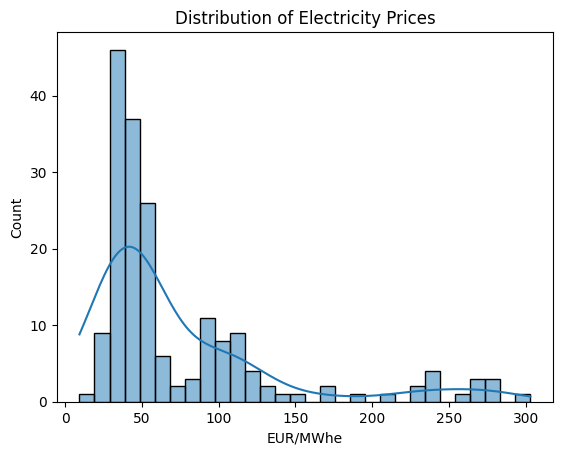

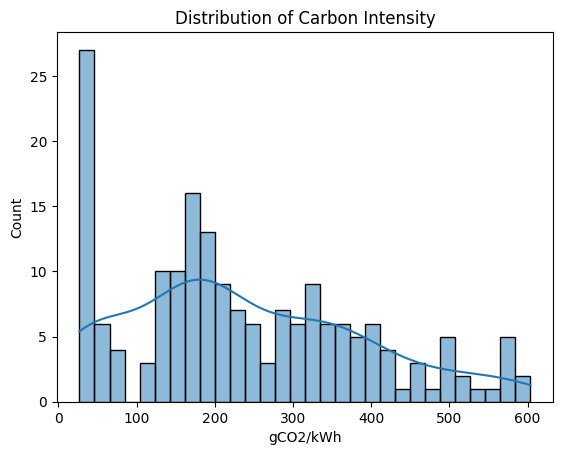

In [184]:
sns.histplot(df['Price (EUR/MWhe)'], bins=30, kde=True)
plt.title('Distribution of Electricity Prices')
plt.xlabel('EUR/MWhe')
plt.show()

# Carbon intensity distribution
sns.histplot(df['Carbon intensity of electricity - gCO2/kWh'], bins=30, kde=True)
plt.title('Distribution of Carbon Intensity')
plt.xlabel('gCO2/kWh')
plt.show()


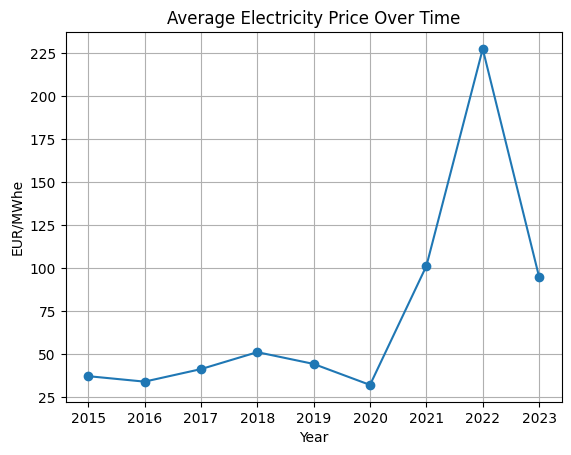

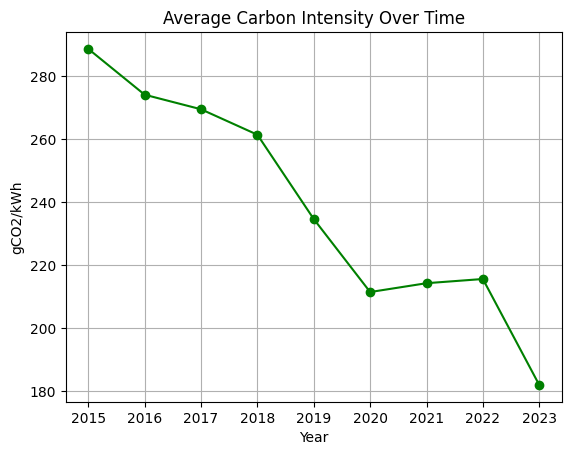

In [185]:
# Average price over years
df.groupby('Year')['Price (EUR/MWhe)'].mean().plot(marker='o')
plt.title('Average Electricity Price Over Time')
plt.ylabel('EUR/MWhe')
plt.grid(True)
plt.show()

# Average carbon intensity over years
df.groupby('Year')['Carbon intensity of electricity - gCO2/kWh'].mean().plot(marker='o', color='green')
plt.title('Average Carbon Intensity Over Time')
plt.ylabel('gCO2/kWh')
plt.grid(True)
plt.show()


#Multiple year cluster analysis

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def cluster_countries_multi_year(df, n_clusters=4):
    """
    Cluster countries based on 2019-2024 averages of:
    - Electricity Price
    - Grid Carbon Intensity
    - Latitude (constant)

    Excludes Serbia from clustering process.
    """
    print("üåç MULTI-YEAR CLUSTERING (2019-2024)")
    print("="*60)

    # Define years and excluded countries
    years = [2016,2017,2018,2019, 2020, 2021, 2022, 2023]
    exclude_countries = ['Serbia']

    print(f"Years included: {years[0]}-{years[-1]}")
    print(f"Excluded countries: {', '.join(exclude_countries)}")

    # Filter for selected years
    df_years = df[df['Year'].isin(years)].copy()

    # Calculate country averages
    country_features = []

    for country in df_years['Country'].unique():
        country_data = df_years[df_years['Country'] == country]

        # Skip if insufficient data
        if len(country_data) < 3:  # Require at least 3 years
            print(f"‚ö†Ô∏è  Skipping {country}: Only {len(country_data)} years of data")
            continue

        # Calculate features
        features = {
            'Country': country,
            'Avg_Price': country_data['Price (EUR/MWhe)'].mean(),
            'Avg_Grid_CI': country_data['Carbon intensity of electricity - gCO2/kWh'].mean(),
            'Latitude': country_data['Latitude'].iloc[0],
            # Additional stats for context
            'Price_Std': country_data['Price (EUR/MWhe)'].std(),
            'Years_Data': len(country_data)
        }

        country_features.append(features)

    features_df = pd.DataFrame(country_features)
    print(f"\nCountries with sufficient data: {len(features_df)}")

    # Separate Serbia from clustering
    serbia_df = features_df[features_df['Country'] == 'Serbia'].copy()
    clustering_df = features_df[features_df['Country'] != 'Serbia'].copy()

    if len(serbia_df) > 0:
        print(f"\nSerbia excluded from clustering:")
        print(f"  Price: {serbia_df['Avg_Price'].values[0]:.1f} EUR/MWh")
        print(f"  Grid CI: {serbia_df['Avg_Grid_CI'].values[0]:.0f} gCO2/kWh")
        print(f"  Latitude: {serbia_df['Latitude'].values[0]:.1f}¬∞N")

    # Prepare features for clustering
    feature_cols = ['Latitude', 'Avg_Grid_CI', 'Avg_Price']
    X = clustering_df[feature_cols].values

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Test different k values if n_clusters='auto'
    if n_clusters == 'auto':
        scores = {}
        for k in range(2, 7):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            scores[k] = silhouette_score(X_scaled, labels)

        n_clusters = max(scores, key=scores.get)
        print(f"\nOptimal clusters: {n_clusters} (silhouette: {scores[n_clusters]:.3f})")
        print(f"All scores: {scores}")

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(X_scaled)
    clustering_df['Cluster'] = clusters

    # Assign Serbia to nearest cluster
    if len(serbia_df) > 0:
        serbia_features = serbia_df[feature_cols].values
        serbia_scaled = scaler.transform(serbia_features)
        serbia_cluster = kmeans.predict(serbia_scaled)[0]
        serbia_df['Cluster'] = serbia_cluster
        print(f"\nSerbia assigned to Cluster {serbia_cluster}")

    # Combine results
    final_df = pd.concat([clustering_df, serbia_df], ignore_index=True)

    # Print cluster summary
    print("\n" + "="*60)
    print("CLUSTER RESULTS")
    print("="*60)

    for cluster in range(n_clusters):
        cluster_data = final_df[final_df['Cluster'] == cluster]
        countries = sorted(cluster_data['Country'].tolist())

        print(f"\nCluster {cluster} ({len(countries)} countries):")
        print(f"  Countries: {', '.join(countries)}")
        if 'Serbia' in countries:
            print(f"  ‚ö†Ô∏è  Contains outlier: Serbia")

        print(f"  Averages:")
        print(f"    ‚Ä¢ Price: {cluster_data['Avg_Price'].mean():.1f} EUR/MWh")
        print(f"    ‚Ä¢ Grid CI: {cluster_data['Avg_Grid_CI'].mean():.0f} gCO2/kWh")
        print(f"    ‚Ä¢ Latitude: {cluster_data['Latitude'].mean():.1f}¬∞N")

    # Create visualizations
    create_visualizations(final_df, n_clusters)

    # Update original dataframe
    country_cluster_map = dict(zip(final_df['Country'], final_df['Cluster']))
    df['Cluster'] = df['Country'].map(country_cluster_map)

    print(f"\n‚úÖ Clustering complete!")

    return df, final_df

def create_visualizations(df, n_clusters):
    """
    Create visualization plots for the clusters
    """
    colors = sns.color_palette('husl', n_clusters)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Latitude vs Grid CI
    ax1 = axes[0, 0]
    for cluster in range(n_clusters):
        cluster_data = df[df['Cluster'] == cluster]

        # Separate Serbia
        regular = cluster_data[cluster_data['Country'] != 'Serbia']
        serbia = cluster_data[cluster_data['Country'] == 'Serbia']

        ax1.scatter(regular['Latitude'], regular['Avg_Grid_CI'],
                   c=[colors[cluster]], label=f'Cluster {cluster}', s=100, alpha=0.7)

        if len(serbia) > 0:
            ax1.scatter(serbia['Latitude'], serbia['Avg_Grid_CI'],
                       c=[colors[cluster]], marker='X', s=200,
                       edgecolors='black', linewidths=2)

    ax1.set_xlabel('Latitude (¬∞N)')
    ax1.set_ylabel('Avg Grid CI (gCO2/kWh)')
    ax1.set_title('Geographic Location vs Carbon Intensity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Grid CI vs Price with country labels
    ax2 = axes[0, 1]
    for cluster in range(n_clusters):
        cluster_data = df[df['Cluster'] == cluster]
        ax2.scatter(cluster_data['Avg_Grid_CI'], cluster_data['Avg_Price'],
                   c=[colors[cluster]], label=f'Cluster {cluster}', s=100, alpha=0.7)

        # Add country labels
        for _, row in cluster_data.iterrows():
            if row['Country'] == 'Serbia':
                ax2.annotate('**SERBIA**', (row['Avg_Grid_CI'], row['Avg_Price']),
                            xytext=(3, 3), textcoords='offset points',
                            fontsize=8, weight='bold', color='red')
            else:
                ax2.annotate(row['Country'], (row['Avg_Grid_CI'], row['Avg_Price']),
                            xytext=(3, 3), textcoords='offset points', fontsize=7)

    ax2.set_xlabel('Avg Grid CI (gCO2/kWh)')
    ax2.set_ylabel('Avg Price (EUR/MWh)')
    ax2.set_title('Carbon Intensity vs Electricity Price')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Cluster sizes
    ax3 = axes[1, 0]
    cluster_sizes = df['Cluster'].value_counts().sort_index()
    bars = ax3.bar(range(n_clusters), cluster_sizes.values, color=colors, alpha=0.7)

    for bar, size in zip(bars, cluster_sizes.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(size), ha='center', va='bottom')

    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Number of Countries')
    ax3.set_title('Countries per Cluster')
    ax3.set_xticks(range(n_clusters))
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Feature comparison
    ax4 = axes[1, 1]

    # Normalize features for comparison
    features = ['Avg_Price', 'Avg_Grid_CI', 'Latitude']
    cluster_means = df.groupby('Cluster')[features].mean()

    # Create grouped bar chart
    x = np.arange(len(features))
    width = 0.8 / n_clusters

    for i in range(n_clusters):
        # Normalize values to percentage of maximum
        values = cluster_means.iloc[i] / df[features].max() * 100
        ax4.bar(x + i * width, values, width,
                label=f'Cluster {i}', color=colors[i], alpha=0.7)

    ax4.set_xlabel('Features')
    ax4.set_ylabel('% of Maximum')
    ax4.set_title('Normalized Feature Comparison')
    ax4.set_xticks(x + width * (n_clusters - 1) / 2)
    ax4.set_xticklabels(['Price', 'Grid CI', 'Latitude'])
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

# Simple usage function
def run_clustering(df):
    """
    Simple wrapper to run the clustering with default settings
    """
    # Run with 4 clusters by default, or use 'auto' to find optimal
    return cluster_countries_multi_year(df, n_clusters=4)

# Example usage:
# df, results = run_clustering(df)
# Or specify clusters:
# df, results = cluster_countries_multi_year(df, n_clusters=5)
# Or find optimal:
# df, results = cluster_countries_multi_year(df, n_clusters='auto')

üåç MULTI-YEAR CLUSTERING (2019-2024)
Years included: 2016-2023
Excluded countries: Serbia

Countries with sufficient data: 21

Optimal clusters: 6 (silhouette: 0.478)
All scores: {2: np.float64(0.3333708773529838), 3: np.float64(0.3311166356373181), 4: np.float64(0.4222457095596583), 5: np.float64(0.4707128987043549), 6: np.float64(0.47770032429107284)}

CLUSTER RESULTS

Cluster 0 (3 countries):
  Countries: Finland, Norway, Sweden
  Averages:
    ‚Ä¢ Price: 53.1 EUR/MWh
    ‚Ä¢ Grid CI: 75 gCO2/kWh
    ‚Ä¢ Latitude: 59.8¬∞N

Cluster 1 (7 countries):
  Countries: Austria, Belgium, France, Lithuania, Luxembourg, Slovakia, Switzerland
  Averages:
    ‚Ä¢ Price: 81.9 EUR/MWh
    ‚Ä¢ Grid CI: 132 gCO2/kWh
    ‚Ä¢ Latitude: 49.6¬∞N

Cluster 2 (4 countries):
  Countries: Denmark, Estonia, Germany, Netherlands
  Averages:
    ‚Ä¢ Price: 73.7 EUR/MWh
    ‚Ä¢ Grid CI: 390 gCO2/kWh
    ‚Ä¢ Latitude: 55.0¬∞N

Cluster 3 (2 countries):
  Countries: Portugal, Spain
  Averages:
    ‚Ä¢ Price: 74.8 

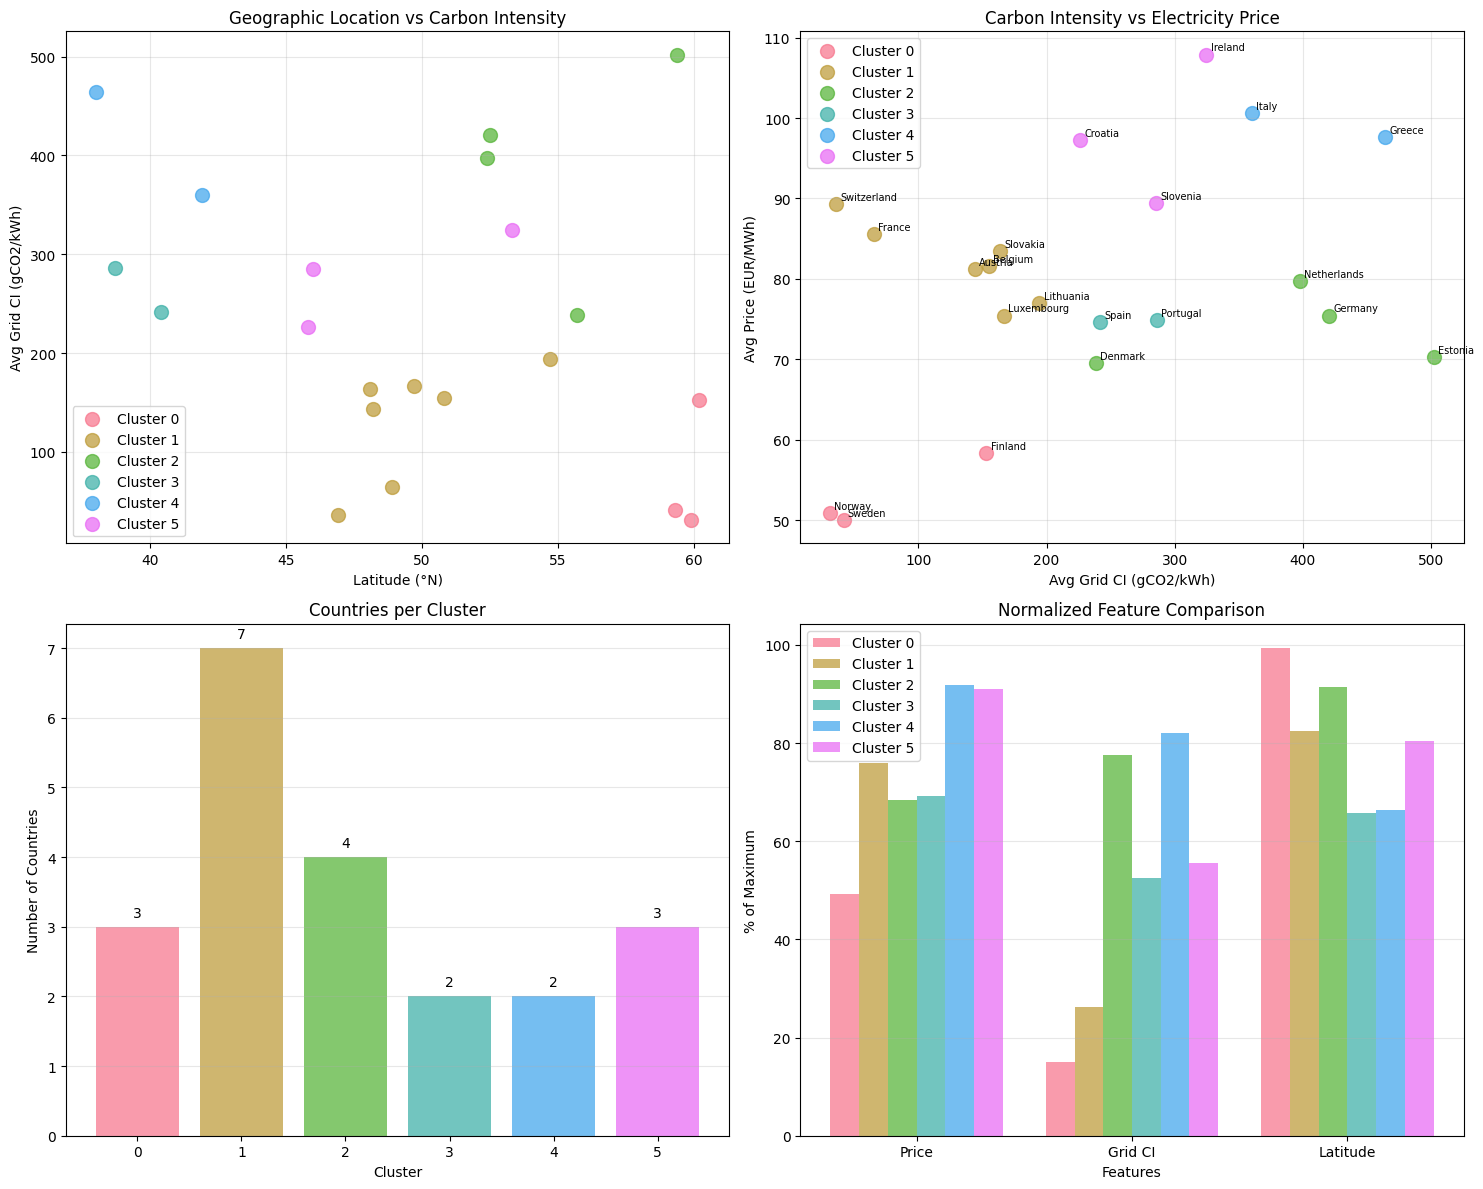


‚úÖ Clustering complete!


In [198]:
# Example usage:
#df, results = run_clustering(df)
# Or specify clusters:
# df, results = cluster_countries_multi_year(df, n_clusters=5)
# Or find optimal:
df, results = cluster_countries_multi_year(df, n_clusters='auto')

#Economical analysis

In [ ]:
df

Country  Year  Latitude  Carbon intensity of electricity - gCO2/kWh  \
0        Austria  2015      48.2                                  172.062160   
1        Austria  2016      48.2                                  154.616910   
2        Austria  2017      48.2                                  162.915500   
3        Austria  2018      48.2                                  157.878460   
4        Austria  2019      48.2                                  152.779740   
..           ...   ...       ...                                         ...   
179  Switzerland  2019      46.9                                   33.867085   
180  Switzerland  2020      46.9                                   35.041615   
181  Switzerland  2021      46.9                                   37.083992   
182  Switzerland  2022      46.9                                   36.132970   
183  Switzerland  2023      46.9                                   34.842716   

    Code  Price (EUR/MWhe)  LCOE  S-opta insolation (kWh/m2¬∑year)  \
0    AUT         31.764167  0,15                           1477.5   
1    AUT         28.956667  0,15                           1477.5   
2    AUT         34.419167  0,15                           1477.5   
3    AUT         40.891667  0,15                           1477.5   
4    AUT         40.137500  0,15                           1477.5   
..   ...               ...   ...                              ...   
179  CHE         40.951667  0,15                           1502.3   
180  CHE         33.988333  0,15                           1502.3   
181  CHE        114.569167  0,15                           1502.3   
182  CHE        280.995833  0,15                           1502.3   
183  CHE        107.785833  0,15                           1502.3   

     S-opta energy yield (kWh/kWp¬∑year)  S-opta (gCO2-eq/kWh)  \
0                                1179.9                  35.1   
1                                1179.9                  35.1   
2                                1179.9                  35.1   
3                                1179.9                  35.1   
4                                1179.9                  35.1   
..                                  ...                   ...   
179                              1195.5                  34.7   
180                              1195.5                  34.7   
181                              1195.5                  34.7   
182                              1195.5                  34.7   
183                              1195.5                  34.7   

     Flat roof (gCO2-eq/kWh)  S-90¬∞ (gCO2-eq/kWh)  W-90¬∞ (gCO2-eq/kWh)  \
0                       42.0                 50.2                 72.2   
1                       42.0                 50.2                 72.2   
2                       42.0                 50.2                 72.2   
3                       42.0                 50.2                 72.2   
4                       42.0                 50.2                 72.2   
..                       ...                  ...                  ...   
179                     41.3                 49.4                 73.1   
180                     41.3                 49.4                 73.1   
181                     41.3                 49.4                 73.1   
182                     41.3                 49.4                 73.1   
183                     41.3                 49.4                 73.1   

     N-90¬∞ (gCO2-eq/kWh)  Cluster  
0                  211.0      1.0  
1                  211.0      1.0  
2                  211.0      1.0  
3                  211.0      1.0  
4                  211.0      1.0  
..                   ...      ...  
179                205.2      1.0  
180                205.2      1.0  
181                205.2      1.0  
182                205.2      1.0  
183                205.2      1.0  

[184 rows x 15 columns]

COMPREHENSIVE CLUSTER ANALYSIS

üìä CLUSTER OVERVIEW
--------------------------------------------------
Cluster 0.0: 3 countries, 27 records
Countries: Finland, Sweden, Norway

Cluster 1.0: 7 countries, 63 records
Countries: Austria, Belgium, France, Lithuania, Luxembourg, Slovakia, Switzerland

Cluster 2.0: 4 countries, 36 records
Countries: Germany, Denmark, Estonia, Netherlands

Cluster 3.0: 2 countries, 18 records
Countries: Spain, Portugal

Cluster 4.0: 2 countries, 18 records
Countries: Greece, Italy

Cluster 5.0: 3 countries, 22 records
Countries: Croatia, Ireland, Slovenia


üìà DETAILED CLUSTER STATISTICS

üè∑Ô∏è  CLUSTER 0.0
------------------------------------------------------------
Countries (3): Finland, Sweden, Norway
Data period: 2015-2023
Total records: 27

üìä Key Metrics Summary:
Metric                              Mean       Median     Min        Max        Std       
-------------------------------------------------------------------------------------
Price (EU

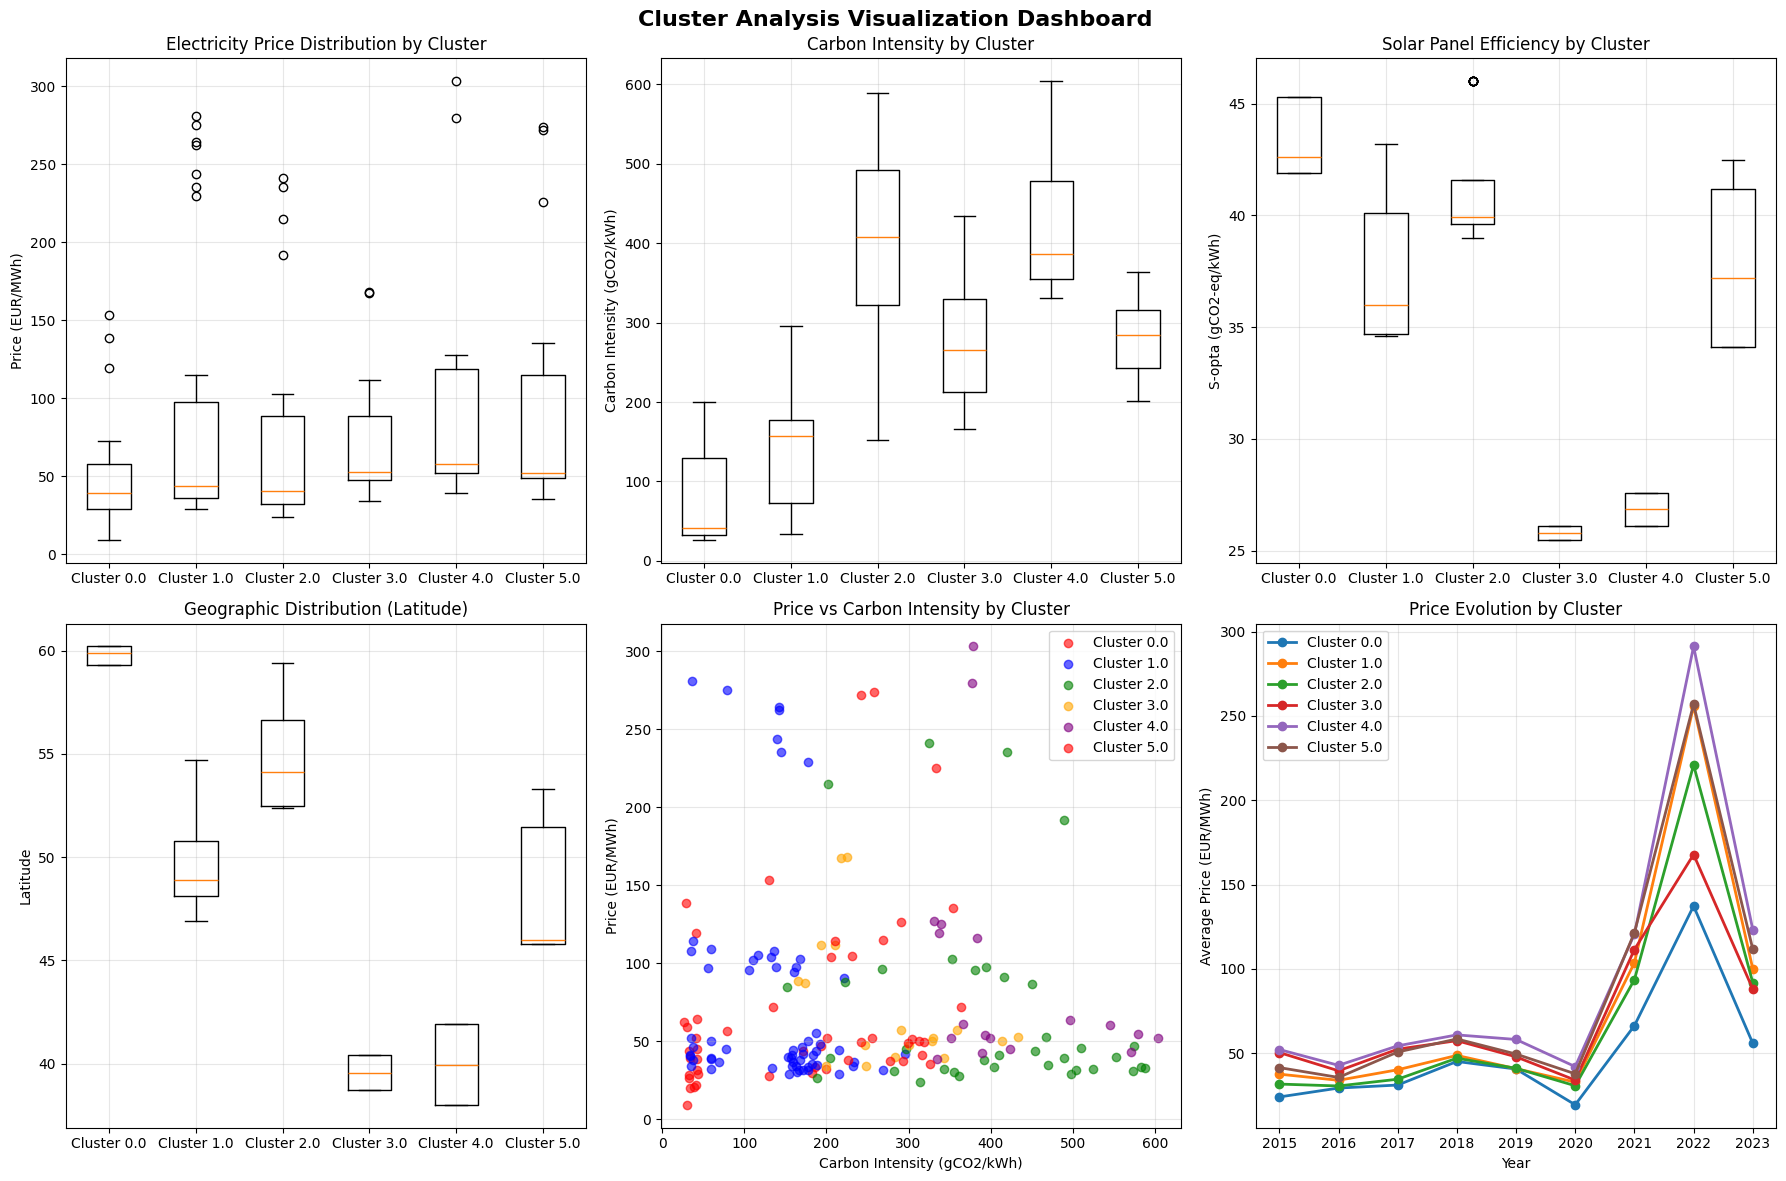


üîó CLUSTER CORRELATION ANALYSIS

üìä Cluster 0.0 Internal Correlations:
                                            Price (EUR/MWhe)  \
Price (EUR/MWhe)                                       1.000   
Carbon intensity of electricity - gCO2/kWh             0.005   
S-opta (gCO2-eq/kWh)                                  -0.029   
Latitude                                               0.086   

                                            Carbon intensity of electricity - gCO2/kWh  \
Price (EUR/MWhe)                                                                 0.005   
Carbon intensity of electricity - gCO2/kWh                                       1.000   
S-opta (gCO2-eq/kWh)                                                            -0.364   
Latitude                                                                         0.659   

                                            S-opta (gCO2-eq/kWh)  Latitude  
Price (EUR/MWhe)                                          -0.029     0.086 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_cluster_statistics(df):
    """
    Create comprehensive statistics for each cluster in the dataset
    """

    # Basic cluster overview
    print("=" * 80)
    print("COMPREHENSIVE CLUSTER ANALYSIS")
    print("=" * 80)

    # Cluster counts and countries
    print("\nüìä CLUSTER OVERVIEW")
    print("-" * 50)
    cluster_countries = df.groupby('Cluster')['Country'].unique()
    cluster_counts = df.groupby('Cluster').size()

    for cluster in sorted(df['Cluster'].unique()):
        countries = cluster_countries[cluster]
        count = cluster_counts[cluster]
        print(f"Cluster {cluster}: {len(countries)} countries, {count} records")
        print(f"Countries: {', '.join(countries)}")
        print()

    # Key variables for analysis
    numeric_vars = ['Price (EUR/MWhe)', 'Carbon intensity of electricity - gCO2/kWh',
                   'S-opta (gCO2-eq/kWh)', 'Flat roof (gCO2-eq/kWh)',
                   'S-90¬∞ (gCO2-eq/kWh)', 'W-90¬∞ (gCO2-eq/kWh)',
                   'N-90¬∞ (gCO2-eq/kWh)', 'Latitude']

    # Statistical summary by cluster
    print("\nüìà DETAILED CLUSTER STATISTICS")
    print("=" * 80)

    cluster_stats = {}

    for cluster in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster]

        print(f"\nüè∑Ô∏è  CLUSTER {cluster}")
        print("-" * 60)

        # Basic info
        countries = cluster_data['Country'].unique()
        years_range = f"{cluster_data['Year'].min()}-{cluster_data['Year'].max()}"

        print(f"Countries ({len(countries)}): {', '.join(countries)}")
        print(f"Data period: {years_range}")
        print(f"Total records: {len(cluster_data)}")

        # Statistical summary
        stats_summary = cluster_data[numeric_vars].describe()

        print(f"\nüìä Key Metrics Summary:")
        print(f"{'Metric':<35} {'Mean':<10} {'Median':<10} {'Min':<10} {'Max':<10} {'Std':<10}")
        print("-" * 85)

        for var in numeric_vars:
            if var in cluster_data.columns:
                mean_val = cluster_data[var].mean()
                median_val = cluster_data[var].median()
                min_val = cluster_data[var].min()
                max_val = cluster_data[var].max()
                std_val = cluster_data[var].std()

                print(f"{var:<35} {mean_val:<10.2f} {median_val:<10.2f} {min_val:<10.2f} {max_val:<10.2f} {std_val:<10.2f}")

        # Store for comparison
        cluster_stats[cluster] = {
            'countries': countries,
            'mean_price': cluster_data['Price (EUR/MWhe)'].mean(),
            'mean_carbon_intensity': cluster_data['Carbon intensity of electricity - gCO2/kWh'].mean(),
            'mean_s_opta': cluster_data['S-opta (gCO2-eq/kWh)'].mean(),
            'mean_latitude': cluster_data['Latitude'].mean(),
            'price_volatility': cluster_data['Price (EUR/MWhe)'].std(),
            'records': len(cluster_data)
        }

        print()

    # Cluster comparison
    print("\nüîç CLUSTER COMPARISON MATRIX")
    print("=" * 80)

    comparison_df = pd.DataFrame(cluster_stats).T
    comparison_df = comparison_df.round(2)

    print("\nPrice Statistics (EUR/MWh):")
    print(f"{'Cluster':<10} {'Mean Price':<12} {'Volatility':<12} {'Countries':<30}")
    print("-" * 70)

    for cluster in sorted(cluster_stats.keys()):
        stats = cluster_stats[cluster]
        countries_str = ', '.join(stats['countries'][:3])  # Show first 3 countries
        if len(stats['countries']) > 3:
            countries_str += f" (+{len(stats['countries'])-3} more)"

        print(f"{cluster:<10} {stats['mean_price']:<12.2f} {stats['price_volatility']:<12.2f} {countries_str:<30}")

    print("\nEnvironmental Characteristics:")
    print(f"{'Cluster':<10} {'Carbon Int.':<12} {'Solar Eff.':<12} {'Latitude':<12}")
    print("-" * 50)

    for cluster in sorted(cluster_stats.keys()):
        stats = cluster_stats[cluster]
        print(f"{cluster:<10} {stats['mean_carbon_intensity']:<12.0f} {stats['mean_s_opta']:<12.1f} {stats['mean_latitude']:<12.1f}")

    return cluster_stats

def create_cluster_visualizations(df):
    """
    Create visualizations for cluster analysis
    """

    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Cluster Analysis Visualization Dashboard', fontsize=16, fontweight='bold')

    # 1. Price distribution by cluster
    axes[0,0].boxplot([df[df['Cluster']==i]['Price (EUR/MWhe)'].values
                       for i in sorted(df['Cluster'].unique())],
                      labels=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())])
    axes[0,0].set_title('Electricity Price Distribution by Cluster')
    axes[0,0].set_ylabel('Price (EUR/MWh)')
    axes[0,0].grid(True, alpha=0.3)

    # 2. Carbon intensity by cluster
    axes[0,1].boxplot([df[df['Cluster']==i]['Carbon intensity of electricity - gCO2/kWh'].values
                       for i in sorted(df['Cluster'].unique())],
                      labels=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())])
    axes[0,1].set_title('Carbon Intensity by Cluster')
    axes[0,1].set_ylabel('Carbon Intensity (gCO2/kWh)')
    axes[0,1].grid(True, alpha=0.3)

    # 3. Solar efficiency (S-opta) by cluster
    axes[0,2].boxplot([df[df['Cluster']==i]['S-opta (gCO2-eq/kWh)'].values
                       for i in sorted(df['Cluster'].unique())],
                      labels=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())])
    axes[0,2].set_title('Solar Panel Efficiency by Cluster')
    axes[0,2].set_ylabel('S-opta (gCO2-eq/kWh)')
    axes[0,2].grid(True, alpha=0.3)

    # 4. Geographic distribution (Latitude)
    axes[1,0].boxplot([df[df['Cluster']==i]['Latitude'].values
                       for i in sorted(df['Cluster'].unique())],
                      labels=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())])
    axes[1,0].set_title('Geographic Distribution (Latitude)')
    axes[1,0].set_ylabel('Latitude')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Price vs Carbon Intensity scatter
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, cluster in enumerate(sorted(df['Cluster'].unique())):
        cluster_data = df[df['Cluster'] == cluster]
        axes[1,1].scatter(cluster_data['Carbon intensity of electricity - gCO2/kWh'],
                         cluster_data['Price (EUR/MWhe)'],
                         c=colors[i % len(colors)],
                         label=f'Cluster {cluster}', alpha=0.6)

    axes[1,1].set_xlabel('Carbon Intensity (gCO2/kWh)')
    axes[1,1].set_ylabel('Price (EUR/MWh)')
    axes[1,1].set_title('Price vs Carbon Intensity by Cluster')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 6. Time series of average price by cluster
    yearly_avg = df.groupby(['Year', 'Cluster'])['Price (EUR/MWhe)'].mean().reset_index()

    for cluster in sorted(df['Cluster'].unique()):
        cluster_data = yearly_avg[yearly_avg['Cluster'] == cluster]
        axes[1,2].plot(cluster_data['Year'], cluster_data['Price (EUR/MWhe)'],
                      marker='o', label=f'Cluster {cluster}', linewidth=2)

    axes[1,2].set_xlabel('Year')
    axes[1,2].set_ylabel('Average Price (EUR/MWh)')
    axes[1,2].set_title('Price Evolution by Cluster')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

def cluster_correlation_analysis(df):
    """
    Analyze correlations within and between clusters
    """
    print("\nüîó CLUSTER CORRELATION ANALYSIS")
    print("=" * 80)

    # Key variables for correlation
    key_vars = ['Price (EUR/MWhe)', 'Carbon intensity of electricity - gCO2/kWh',
               'S-opta (gCO2-eq/kWh)', 'Latitude']

    for cluster in sorted(df['Cluster'].unique()):
        print(f"\nüìä Cluster {cluster} Internal Correlations:")
        cluster_data = df[df['Cluster'] == cluster]
        corr_matrix = cluster_data[key_vars].corr()
        print(corr_matrix.round(3))

def investment_attractiveness_by_cluster(df):
    """
    Calculate investment attractiveness metrics by cluster
    """
    print("\nüí∞ INVESTMENT ATTRACTIVENESS BY CLUSTER")
    print("=" * 80)

    cluster_investment = df.groupby('Cluster').agg({
        'Price (EUR/MWhe)': ['mean', 'std', 'min', 'max'],
        'Carbon intensity of electricity - gCO2/kWh': 'mean',
        'S-opta (gCO2-eq/kWh)': 'mean',
        'Country': 'nunique'
    }).round(2)

    cluster_investment.columns = ['Avg_Price', 'Price_Volatility', 'Min_Price', 'Max_Price',
                                 'Avg_Carbon_Intensity', 'Avg_Solar_Efficiency', 'Num_Countries']

    # Calculate investment scores
    cluster_investment['Revenue_Score'] = (cluster_investment['Avg_Price'] - cluster_investment['Avg_Price'].min()) / (cluster_investment['Avg_Price'].max() - cluster_investment['Avg_Price'].min()) * 100

    cluster_investment['Environmental_Score'] = (cluster_investment['Avg_Carbon_Intensity'] - cluster_investment['Avg_Carbon_Intensity'].min()) / (cluster_investment['Avg_Carbon_Intensity'].max() - cluster_investment['Avg_Carbon_Intensity'].min()) * 100

    cluster_investment['Efficiency_Score'] = (cluster_investment['Avg_Solar_Efficiency'].max() - cluster_investment['Avg_Solar_Efficiency']) / (cluster_investment['Avg_Solar_Efficiency'].max() - cluster_investment['Avg_Solar_Efficiency'].min()) * 100

    cluster_investment['Overall_Score'] = (cluster_investment['Revenue_Score'] * 0.5 +
                                          cluster_investment['Environmental_Score'] * 0.3 +
                                          cluster_investment['Efficiency_Score'] * 0.2)

    print(cluster_investment.round(1))

    # Rank clusters
    print(f"\nüèÜ CLUSTER RANKING BY INVESTMENT ATTRACTIVENESS:")
    ranking = cluster_investment.sort_values('Overall_Score', ascending=False)

    for i, (cluster, row) in enumerate(ranking.iterrows()):
        print(f"{i+1}. Cluster {cluster}: {row['Overall_Score']:.1f} points")
        print(f"   Revenue: {row['Revenue_Score']:.1f}, Environmental: {row['Environmental_Score']:.1f}, Efficiency: {row['Efficiency_Score']:.1f}")

    return cluster_investment

# Main execution function
def analyze_clusters(df):
    """
    Run complete cluster analysis
    """
    # Create statistics
    cluster_stats = create_cluster_statistics(df)

    # Create visualizations
    create_cluster_visualizations(df)

    # Correlation analysis
    cluster_correlation_analysis(df)

    # Investment attractiveness
    investment_scores = investment_attractiveness_by_cluster(df)

    return cluster_stats, investment_scores

# Usage:
cluster_stats, investment_scores = analyze_clusters(df)

In [ ]:
import pandas as pd
import numpy as np

def calculate_go_cost_and_carbon_effectiveness(df, go_price_scenarios=None):
    """
    Calculate GO certificate costs and solar carbon effectiveness

    GO certificates are a PREMIUM/COST paid to certify electricity comes from renewable sources

    Parameters:
    df: DataFrame with columns 'Carbon intensity of electricity - gCO2/kWh' and 'S-opta (gCO2-eq/kWh)'
    go_price_scenarios: list of GO prices in Euro/gCO2_eq (default: [0.3, 0.5, 1.0, 3.0, 10.0])

    Returns:
    DataFrame with original data plus calculated metrics
    """

    if go_price_scenarios is None:
        go_price_scenarios = [0.3, 0.5, 1.0, 3.0, 10.0]

    # Create a copy to avoid modifying original dataframe
    df_enhanced = df.copy()

    # Extract relevant columns with shorter names for easier calculation
    E_CI = df_enhanced['Carbon intensity of electricity - gCO2/kWh']  # Grid carbon intensity
    PV_CI = df_enhanced['Flat roof (gCO2-eq/kWh)']  # Solar panel carbon intensity

    # Formula 1: GO certificate cost calculation (PREMIUM paid for clean electricity certification)
    print("üí∏ CALCULATING GO CERTIFICATE COSTS (Premium for Clean Electricity)")
    print("=" * 70)

    for go_price in go_price_scenarios:
        # GO cost (Euro/kWh) = P_GOS (Euro/gCO2_eq) * E_CI (gCO2_eq/kWh)
        # Higher carbon intensity = Higher premium to "certify" as clean
        go_cost_column = f'GO_premium_‚Ç¨{go_price}_per_gCO2'
        df_enhanced[go_cost_column] = (go_price / 1000) * E_CI  # Divide by 1000 to convert g to kg for proper units

        print(f"GO Price ‚Ç¨{go_price}/gCO2: Average premium = ‚Ç¨{df_enhanced[go_cost_column].mean():.4f}/kWh")

    # Total electricity cost including GO premium
    electricity_price = df_enhanced['Price (EUR/MWhe)'] / 1000  # Convert MWh to kWh

    for go_price in go_price_scenarios:
        total_cost_column = f'Total_electricity_cost_with_GO_‚Ç¨{go_price}'
        go_cost_column = f'GO_premium_‚Ç¨{go_price}_per_gCO2'
        df_enhanced[total_cost_column] = electricity_price + df_enhanced[go_cost_column]

        print(f"Average total electricity cost (with ‚Ç¨{go_price}/gCO2 GO): ‚Ç¨{df_enhanced[total_cost_column].mean():.4f}/kWh")

    # Formula 2: Solar carbon effectiveness
    print(f"\nüå± CALCULATING SOLAR CARBON EFFECTIVENESS")
    print("=" * 50)

    # Solar carbon effectiveness = (E_CI - PV_CI) / E_CI
    df_enhanced['Solar_carbon_effectiveness'] = (E_CI - PV_CI) / E_CI

    # Handle any potential division by zero or negative values
    df_enhanced['Solar_carbon_effectiveness'] = df_enhanced['Solar_carbon_effectiveness'].clip(lower=0)

    # Convert to percentage for easier interpretation
    df_enhanced['Solar_carbon_effectiveness_pct'] = df_enhanced['Solar_carbon_effectiveness'] * 100

    print(f"Average solar carbon effectiveness: {df_enhanced['Solar_carbon_effectiveness_pct'].mean():.1f}%")
    print(f"Range: {df_enhanced['Solar_carbon_effectiveness_pct'].min():.1f}% - {df_enhanced['Solar_carbon_effectiveness_pct'].max():.1f}%")

    # Additional derived metrics
    print(f"\nüìä ADDITIONAL DERIVED METRICS")
    print("=" * 50)

    # Absolute carbon savings per kWh (solar vs grid)
    df_enhanced['Carbon_savings_per_kWh'] = E_CI - PV_CI
    df_enhanced['Carbon_savings_per_kWh'] = df_enhanced['Carbon_savings_per_kWh'].clip(lower=0)

    print(f"Average carbon savings from solar: {df_enhanced['Carbon_savings_per_kWh'].mean():.1f} gCO2/kWh")

    # GO cost avoidance by using solar instead of grid+GO certificates
    for go_price in go_price_scenarios:
        avoidance_column = f'GO_cost_avoidance_‚Ç¨{go_price}'
        go_cost_column = f'GO_premium_‚Ç¨{go_price}_per_gCO2'
        # If you use solar, you avoid paying GO premiums on grid electricity
        df_enhanced[avoidance_column] = df_enhanced[go_cost_column]
        print(f"GO cost avoidance with solar (‚Ç¨{go_price}/gCO2): ‚Ç¨{df_enhanced[avoidance_column].mean():.4f}/kWh")

    return df_enhanced

def analyze_metrics_by_cluster(df_enhanced, go_price_scenarios=None):
    """
    Analyze the calculated metrics by cluster
    """

    if go_price_scenarios is None:
        go_price_scenarios = [0.3, 0.5, 1.0, 3.0, 10.0]

    print(f"\nüéØ CLUSTER-BASED ANALYSIS")
    print("=" * 80)

    # Group by cluster and calculate statistics
    cluster_stats = df_enhanced.groupby('Cluster').agg({
        'Carbon intensity of electricity - gCO2/kWh': ['mean', 'std'],
        'S-opta (gCO2-eq/kWh)': ['mean', 'std'],
        'Solar_carbon_effectiveness_pct': ['mean', 'std', 'min', 'max'],
        'Carbon_savings_per_kWh': ['mean', 'std'],
        'Country': 'nunique'
    }).round(2)

    print("Carbon Effectiveness by Cluster:")
    print(f"{'Cluster':<8} {'Countries':<10} {'Avg Effectiveness':<18} {'Carbon Savings':<15} {'Grid Carbon':<12}")
    print("-" * 70)

    for cluster in sorted(df_enhanced['Cluster'].unique()):
        cluster_data = df_enhanced[df_enhanced['Cluster'] == cluster]
        countries = cluster_data['Country'].nunique()
        avg_effectiveness = cluster_data['Solar_carbon_effectiveness_pct'].mean()
        avg_savings = cluster_data['Carbon_savings_per_kWh'].mean()
        avg_grid_carbon = cluster_data['Carbon intensity of electricity - gCO2/kWh'].mean()

        print(f"{cluster:<8} {countries:<10} {avg_effectiveness:<18.1f}% {avg_savings:<15.0f}g/kWh {avg_grid_carbon:<12.0f}g/kWh")

    # GO cost analysis by cluster (cost to certify grid electricity as clean)
    print(f"\nüí∏ GO CERTIFICATE PREMIUM COSTS BY CLUSTER")
    print("-" * 80)
    print(f"{'Cluster':<8} {'‚Ç¨0.3/gCO2':<12} {'‚Ç¨1.0/gCO2':<12} {'‚Ç¨3.0/gCO2':<12} {'‚Ç¨10.0/gCO2':<12}")
    print("-" * 60)

    for cluster in sorted(df_enhanced['Cluster'].unique()):
        cluster_data = df_enhanced[df_enhanced['Cluster'] == cluster]
        row = f"{cluster:<8} "

        for price in [0.3, 1.0, 3.0, 10.0]:
            if f'GO_premium_‚Ç¨{price}_per_gCO2' in cluster_data.columns:
                avg_premium = cluster_data[f'GO_premium_‚Ç¨{price}_per_gCO2'].mean()
                row += f"{avg_premium:<12.4f} "

        print(row)

    # Solar advantage analysis (avoiding GO costs)
    print(f"\nüåû SOLAR ADVANTAGE: GO COST AVOIDANCE BY CLUSTER")
    print("-" * 80)
    print("(How much you save by using solar instead of paying GO premiums on grid electricity)")
    print(f"{'Cluster':<8} {'‚Ç¨0.3/gCO2':<12} {'‚Ç¨1.0/gCO2':<12} {'‚Ç¨3.0/gCO2':<12} {'‚Ç¨10.0/gCO2':<12}")
    print("-" * 60)

    for cluster in sorted(df_enhanced['Cluster'].unique()):
        cluster_data = df_enhanced[df_enhanced['Cluster'] == cluster]
        row = f"{cluster:<8} "

        for price in [0.3, 1.0, 3.0, 10.0]:
            if f'GO_cost_avoidance_‚Ç¨{price}' in cluster_data.columns:
                avg_avoidance = cluster_data[f'GO_cost_avoidance_‚Ç¨{price}'].mean()
                row += f"{avg_avoidance:<12.4f} "

        print(row)

    return cluster_stats

def create_effectiveness_summary_table(df_enhanced):
    """
    Create a summary table of key effectiveness metrics and GO cost analysis
    """

    print(f"\nüìã EFFECTIVENESS & GO COST SUMMARY TABLE")
    print("=" * 100)

    summary_stats = df_enhanced.groupby(['Cluster', 'Country']).agg({
        'Solar_carbon_effectiveness_pct': 'mean',
        'Carbon_savings_per_kWh': 'mean',
        'Carbon intensity of electricity - gCO2/kWh': 'mean',
        'S-opta (gCO2-eq/kWh)': 'mean',
        'GO_premium_‚Ç¨1.0_per_gCO2': 'mean',  # GO cost premium at ‚Ç¨1.0/gCO2
        'Total_electricity_cost_with_GO_‚Ç¨1.0': 'mean'  # Total electricity cost including GO premium
    }).round(4)

    summary_stats = summary_stats.sort_values('Solar_carbon_effectiveness_pct', ascending=False)

    print(f"{'Country':<12} {'Cluster':<8} {'Carbon Eff.':<12} {'Savings':<10} {'Grid CI':<8} {'GO Premium':<11} {'Total Cost':<10}")
    print("-" * 90)

    for (cluster, country), row in summary_stats.head(15).iterrows():  # Top 15 countries
        print(f"{country:<12} {cluster:<8} {row['Solar_carbon_effectiveness_pct']:<12.1f}% "
              f"{row['Carbon_savings_per_kWh']:<10.0f} {row['Carbon intensity of electricity - gCO2/kWh']:<8.0f} "
              f"‚Ç¨{row['GO_premium_‚Ç¨1.0_per_gCO2']:<10.4f} ‚Ç¨{row['Total_electricity_cost_with_GO_‚Ç¨1.0']:<9.4f}")

    print(f"\nNote: GO Premium = Extra cost to certify grid electricity as renewable")
    print(f"Total Cost = Base electricity price + GO premium")
    print(f"Using solar avoids both base electricity costs AND GO premiums")

# Main execution function
def run_go_carbon_analysis(df, go_price_scenarios=None):
    """
    Run complete GO certificate cost and carbon effectiveness analysis

    GO certificates are PREMIUMS paid to certify electricity comes from renewable sources.
    This analysis shows:
    1. How much extra you pay for "clean" grid electricity certification
    2. How much carbon reduction you get from solar vs grid
    3. The economic advantage of solar (avoiding both electricity costs AND GO premiums)
    """

    print("üöÄ STARTING GO CERTIFICATE COST AND CARBON EFFECTIVENESS ANALYSIS")
    print("=" * 80)
    print("GO Certificates = PREMIUM paid to certify electricity as renewable")
    print("Higher carbon intensity electricity = Higher GO premium costs")
    print("Solar avoids both electricity costs AND GO premiums")
    print("=" * 80)

    # Calculate metrics
    df_enhanced = calculate_go_cost_and_carbon_effectiveness(df, go_price_scenarios)

    # Analyze by cluster
    cluster_stats = analyze_metrics_by_cluster(df_enhanced, go_price_scenarios)

    # Create summary table
    create_effectiveness_summary_table(df_enhanced)

    print(f"\n‚úÖ ANALYSIS COMPLETE!")
    print(f"Enhanced dataset contains {len(df_enhanced.columns)} columns (added {len(df_enhanced.columns) - len(df.columns)} new metrics)")
    print(f"\nKey insights:")
    print(f"- Countries with high carbon intensity pay more for GO certificate premiums")
    print(f"- Solar provides double advantage: clean energy + avoids GO costs")
    print(f"- Carbon effectiveness shows environmental benefit of solar vs grid")

    return df_enhanced, cluster_stats

# Usage:
# df_enhanced, cluster_stats = run_go_carbon_analysis(df)
#
# Or with custom GO price scenarios:
# df_enhanced, cluster_stats = run_go_carbon_analysis(df, go_price_scenarios=[0.5, 2.0, 5.0])
#
# This will calculate:
# 1. GO certificate premiums (cost to certify grid electricity as renewable)
# 2. Solar carbon effectiveness (% carbon reduction vs grid)
# 3. Total electricity costs (base price + GO premium)
# 4. Economic advantage of solar (avoiding GO costs)
# 5. Cluster-based analysis of all metrics

In [ ]:
df_enhanced, cluster_stats = run_go_carbon_analysis(df)

üöÄ STARTING GO CERTIFICATE COST AND CARBON EFFECTIVENESS ANALYSIS
GO Certificates = PREMIUM paid to certify electricity as renewable
Higher carbon intensity electricity = Higher GO premium costs
Solar avoids both electricity costs AND GO premiums
üí∏ CALCULATING GO CERTIFICATE COSTS (Premium for Clean Electricity)
GO Price ‚Ç¨0.3/gCO2: Average premium = ‚Ç¨0.0714/kWh
GO Price ‚Ç¨0.5/gCO2: Average premium = ‚Ç¨0.1190/kWh
GO Price ‚Ç¨1.0/gCO2: Average premium = ‚Ç¨0.2380/kWh
GO Price ‚Ç¨3.0/gCO2: Average premium = ‚Ç¨0.7140/kWh
GO Price ‚Ç¨10.0/gCO2: Average premium = ‚Ç¨2.3800/kWh
Average total electricity cost (with ‚Ç¨0.3/gCO2 GO): ‚Ç¨0.1462/kWh
Average total electricity cost (with ‚Ç¨0.5/gCO2 GO): ‚Ç¨0.1938/kWh
Average total electricity cost (with ‚Ç¨1.0/gCO2 GO): ‚Ç¨0.3128/kWh
Average total electricity cost (with ‚Ç¨3.0/gCO2 GO): ‚Ç¨0.7888/kWh
Average total electricity cost (with ‚Ç¨10.0/gCO2 GO): ‚Ç¨2.4548/kWh

üå± CALCULATING SOLAR CARBON EFFECTIVENESS
Average solar carbon eff

#Economic analysis

##GO vs PV

In [199]:
import pandas as pd
import numpy as np

def step1_cluster_level_go_vs_pv_analysis(df, go_price_per_mwh=0.5):
    """
    Step 1: Cluster-level GO vs PV strategic analysis for corporate decision-making

    Parameters:
    df: DataFrame with your enhanced dataset
    go_price_per_mwh: GO certificate price in EUR/MWh (default: 0.5)

    Returns:
    DataFrame with cluster-level strategic analysis
    """

    print("üè¢ STEP 1: CLUSTER-LEVEL GO vs PV CORPORATE STRATEGY ANALYSIS")
    print("=" * 70)

    # Create working copy and calculate basic metrics
    df_work = df.copy()

    # Convert LCOE and Electricity price from EUR/MWh to EUR/kWh for easier comparison with LCOE
    df_work['Electricity_price_kWh'] = df_work['Price (EUR/MWhe)'] / 1000

    # GO Strategy Costs
    df_work['GO_premium_kWh'] = go_price_per_mwh / 1000  # Convert to EUR/kWh
    df_work['GO_total_cost_kWh'] = df_work['Electricity_price_kWh'] + df_work['GO_premium_kWh']

    # PV Strategy Costs (LCOE already in EUR/kWh)
    df_work['PV_total_cost_kWh'] = df_work['LCOE']

    # Corporate Financial Analysis
    df_work['Corporate_savings_GO_vs_PV'] = df_work['GO_total_cost_kWh'] - df_work['PV_total_cost_kWh']
    df_work['Cost_advantage_percentage'] = (df_work['Corporate_savings_GO_vs_PV'] / df_work['GO_total_cost_kWh']) * 100

    # Carbon Effectiveness Analysis
    df_work['Carbon_effectiveness_PV'] = (df_work['Carbon intensity of electricity - gCO2/kWh'] -
                                        df_work['S-opta (gCO2-eq/kWh)']) / df_work['Carbon intensity of electricity - gCO2/kWh']
    df_work['Carbon_effectiveness_PV'] = df_work['Carbon_effectiveness_PV'].clip(lower=0) * 100

    # Use 2024 data for current strategic analysis (or latest available year)
    if 2024 in df_work['Year'].values:
        analysis_year = 2024
    else:
        analysis_year = df_work['Year'].max()
        print(f"‚ö†Ô∏è  2024 data not available, using {analysis_year} instead")

    df_latest = df_work[df_work['Year'] == analysis_year].copy()

    print(f"üìä Analyzing {len(df_latest)} countries in {len(df_latest['Cluster'].unique())} clusters ({analysis_year} data)")

    # CLUSTER-LEVEL AGGREGATION
    cluster_analysis = df_latest.groupby('Cluster').agg({
        'Country': ['count', lambda x: list(x)],
        'GO_total_cost_kWh': ['median', 'std'],
        'PV_total_cost_kWh': ['median', 'std'],
        'Corporate_savings_GO_vs_PV': ['median', 'std'],
        'Cost_advantage_percentage': ['median', 'std'],
        'Carbon_effectiveness_PV': ['median', 'std'],
        'Carbon intensity of electricity - gCO2/kWh': 'median',
        'S-opta (gCO2-eq/kWh)': 'median'
    }).round(4)

    # Flatten column names
    cluster_analysis.columns = [
        'Country_count', 'Countries_list',
        'GO_cost_median', 'GO_cost_std',
        'PV_cost_median', 'PV_cost_std',
        'Savings_median', 'Savings_std',
        'Cost_advantage_median', 'Cost_advantage_std',
        'Carbon_eff_median', 'Carbon_eff_std',
        'Grid_carbon_intensity', 'PV_carbon_intensity'
    ]

    # CLUSTER COHERENCE ASSESSMENT
    cluster_analysis['Economic_coherence'] = 1 / (1 + cluster_analysis['Savings_std'] / abs(cluster_analysis['Savings_median'] + 0.001))
    cluster_analysis['Carbon_coherence'] = 1 / (1 + cluster_analysis['Carbon_eff_std'] / (cluster_analysis['Carbon_eff_median'] + 1))
    cluster_analysis['Overall_coherence'] = (cluster_analysis['Economic_coherence'] + cluster_analysis['Carbon_coherence']) / 2

    # CLUSTER-LEVEL STRATEGIC RECOMMENDATIONS
    def get_cluster_recommendation(row):
        savings = row['Savings_median']
        carbon_eff = row['Carbon_eff_median']
        coherence = row['Overall_coherence']

        # Confidence levels based on coherence
        if coherence > 0.7:
            confidence = "HIGH"
        elif coherence > 0.5:
            confidence = "MEDIUM"
        else:
            confidence = "LOW"

        # Strategic logic
        if savings > 0.005:  # >‚Ç¨5/MWh savings
            if carbon_eff > 50:
                strategy = "PV_OPTIMAL"
                rationale = "Strong economic and environmental advantages"
            else:
                strategy = "PV_ECONOMIC"
                rationale = "Economic advantage, limited environmental benefit"
        elif savings > -0.005:  # Within ¬±‚Ç¨5/MWh
            if carbon_eff > 50:
                strategy = "PV_ENVIRONMENTAL"
                rationale = "Economic parity, strong environmental case"
            else:
                strategy = "STRATEGY_NEUTRAL"
                rationale = "Similar economic and environmental outcomes"
        else:  # GO cheaper
            if carbon_eff < 30:
                strategy = "GO_PREFERRED"
                rationale = "GO cost advantage, limited PV environmental benefit"
            else:
                strategy = "GO_COST_PV_ENV"
                rationale = "Trade-off: GO cheaper but PV more credible"

        return f"{strategy}_{confidence}", strategy, rationale, confidence

    recommendations = cluster_analysis.apply(get_cluster_recommendation, axis=1, result_type='expand')
    cluster_analysis[['Full_recommendation', 'Strategy', 'Rationale', 'Confidence']] = recommendations

    # CREDIBILITY ASSESSMENT
    cluster_analysis['Carbon_credibility_gap'] = 100 - cluster_analysis['Carbon_eff_median']  # GO assumes 100% clean
    cluster_analysis['Credibility_risk'] = np.where(
        cluster_analysis['Carbon_credibility_gap'] > 50, 'HIGH',
        np.where(cluster_analysis['Carbon_credibility_gap'] > 25, 'MEDIUM', 'LOW')
    )

    print(f"\nüéØ CLUSTER STRATEGIC RECOMMENDATIONS:")
    print("=" * 80)
    print(f"{'Cluster':<8} {'Countries':<10} {'Strategy':<18} {'Confidence':<10} {'Economic':<12} {'Environmental':<13}")
    print("-" * 85)

    for cluster in sorted(cluster_analysis.index):
        row = cluster_analysis.loc[cluster]
        countries_str = f"{row['Country_count']} countries"
        savings_str = f"‚Ç¨{row['Savings_median']*1000:+.0f}/MWh"
        carbon_str = f"{row['Carbon_eff_median']:.0f}% reduction"

        print(f"{cluster:<8} {countries_str:<10} {row['Strategy']:<18} {row['Confidence']:<10} {savings_str:<12} {carbon_str:<13}")
        print(f"         {row['Rationale']}")
        print()

    return cluster_analysis, df_work

def assess_cluster_validity(cluster_analysis):
    """
    Assess the validity of cluster-level recommendations
    """

    print(f"\nüîç CLUSTER VALIDITY ASSESSMENT")
    print("=" * 60)

    validity_issues = []

    for cluster in sorted(cluster_analysis.index):
        row = cluster_analysis.loc[cluster]

        print(f"\nüè∑Ô∏è  CLUSTER {cluster}")
        print(f"Countries: {', '.join(row['Countries_list'][:4])}{'...' if len(row['Countries_list']) > 4 else ''}")
        print(f"Overall coherence: {row['Overall_coherence']:.2f}")
        print(f"Economic coherence: {row['Economic_coherence']:.2f}")
        print(f"Carbon coherence: {row['Carbon_coherence']:.2f}")

        # Flag potential issues
        if row['Overall_coherence'] < 0.5:
            validity_issues.append(f"Cluster {cluster}: Low coherence ({row['Overall_coherence']:.2f})")
            print("‚ö†Ô∏è  WARNING: Low cluster coherence - recommendation may not apply to all countries")

        if row['Savings_std'] > 0.01:  # >‚Ç¨10/MWh standard deviation
            validity_issues.append(f"Cluster {cluster}: High economic variation")
            print("‚ö†Ô∏è  WARNING: High economic variation within cluster")

        if row['Carbon_eff_std'] > 20:  # >20 percentage points std dev
            validity_issues.append(f"Cluster {cluster}: High carbon effectiveness variation")
            print("‚ö†Ô∏è  WARNING: High carbon effectiveness variation within cluster")

        if row['Overall_coherence'] > 0.7:
            print("‚úÖ HIGH CONFIDENCE: Cluster recommendation highly reliable")
        elif row['Overall_coherence'] > 0.5:
            print("‚úÖ MEDIUM CONFIDENCE: Cluster recommendation reasonably reliable")

    if validity_issues:
        print(f"\n‚ö†Ô∏è  VALIDITY CONCERNS:")
        for issue in validity_issues:
            print(f"   - {issue}")
    else:
        print(f"\n‚úÖ ALL CLUSTERS SHOW GOOD COHERENCE FOR STRATEGIC RECOMMENDATIONS")

    return validity_issues

# Usage:
# cluster_analysis, df_enhanced = step1_cluster_level_go_vs_pv_analysis(df)
# validity_issues = assess_cluster_validity(cluster_analysis)
#
# This creates:
# - cluster_analysis: DataFrame with one row per cluster containing strategic recommendations
# - Coherence scores to assess recommendation reliability
# - Strategic typologies for corporate decision-making
# - Confidence levels for each cluster recommendation

In [200]:
cluster_analysis, df_enhanced = step1_cluster_level_go_vs_pv_analysis(df)

üè¢ STEP 1: CLUSTER-LEVEL GO vs PV CORPORATE STRATEGY ANALYSIS
‚ö†Ô∏è  2024 data not available, using 2023 instead
üìä Analyzing 21 countries in 6 clusters (2023 data)

üéØ CLUSTER STRATEGIC RECOMMENDATIONS:
Cluster  Countries  Strategy           Confidence Economic     Environmental
-------------------------------------------------------------------------------------
0.0      3 countries GO_PREFERRED       MEDIUM     ‚Ç¨-130/MWh    0% reduction 
         GO cost advantage, limited PV environmental benefit

1.0      7 countries GO_COST_PV_ENV     HIGH       ‚Ç¨-62/MWh     68% reduction
         Trade-off: GO cheaper but PV more credible

2.0      4 countries GO_COST_PV_ENV     HIGH       ‚Ç¨-79/MWh     87% reduction
         Trade-off: GO cheaper but PV more credible

3.0      2 countries GO_COST_PV_ENV     HIGH       ‚Ç¨-22/MWh     85% reduction
         Trade-off: GO cheaper but PV more credible

4.0      2 countries PV_OPTIMAL         HIGH       ‚Ç¨+9/MWh      92% reduction
     

In [ ]:
validity_issues = assess_cluster_validity(cluster_analysis)

##Risk analytics

In [ ]:
import pandas as pd
import numpy as np

def step1_cluster_level_go_vs_pv_sobriety_analysis_v2(df, go_price_per_mwh=0.5, sobriety_cost_per_kwh=0.04):
    """
    Step 1: CLEAN VERSION - Cluster-level GO vs PV vs Energy Sobriety strategic analysis
    Uses 2024 data (or most recent available) for current strategic decisions

    Sobriety ONLY recommended for very clean grids (CI < 100) where PV is counterproductive
    """

    print("üè¢ STEP 1: CLEAN GO vs PV vs SOBRIETY ANALYSIS (Version 2)")
    print("=" * 70)
    print("üîß Sobriety Criteria: Grid CI < 100 gCO2/kWh AND PV CI gap > 10 gCO2/kWh")
    print("üîß Economic logic: PV vs GO comparison, sobriety only for environmental cases")
    print("=" * 70)

    # Create working copy
    df_work = df.copy()

    # Convert LCOE to numeric
    df_work['LCOE'] = df_work['LCOE'].str.replace(',', '.').astype(float)

    # Basic cost calculations
    df_work['Electricity_price_kWh'] = df_work['Price (EUR/MWhe)'] / 1000
    df_work['GO_premium_kWh'] = go_price_per_mwh / 1000
    df_work['GO_total_cost_kWh'] = df_work['Electricity_price_kWh'] + df_work['GO_premium_kWh']
    df_work['PV_total_cost_kWh'] = df_work['LCOE']
    df_work['Sobriety_cost_kWh'] = sobriety_cost_per_kwh

    # Financial comparisons
    df_work['Corporate_savings_GO_vs_PV'] = df_work['GO_total_cost_kWh'] - df_work['PV_total_cost_kWh']
    df_work['Corporate_savings_GO_vs_Sobriety'] = df_work['GO_total_cost_kWh'] - df_work['Sobriety_cost_kWh']

    # Carbon analysis
    df_work['Carbon_effectiveness_PV'] = (
        (df_work['Carbon intensity of electricity - gCO2/kWh'] - df_work['S-opta (gCO2-eq/kWh)']) /
        df_work['Carbon intensity of electricity - gCO2/kWh']
    ).clip(lower=0) * 100

    # Clean grid checks
    df_work['CI_gap'] = df_work['S-opta (gCO2-eq/kWh)'] - df_work['Carbon intensity of electricity - gCO2/kWh']
    df_work['Very_clean_grid'] = df_work['Carbon intensity of electricity - gCO2/kWh'] < 100
    df_work['Significant_CI_gap'] = df_work['CI_gap'] > 10
    df_work['Sobriety_environmental_case'] = df_work['Very_clean_grid'] & df_work['Significant_CI_gap']

    # Use 2024 data
    if 2024 in df_work['Year'].values:
        analysis_year = 2024
    else:
        analysis_year = df_work['Year'].max()
        print(f"‚ö†Ô∏è 2024 data not available, using {analysis_year}")

    df_latest = df_work[df_work['Year'] == analysis_year].copy()

    print(f"üìä Analyzing {len(df_latest)} countries in {len(df_latest['Cluster'].unique())} clusters ({analysis_year})")

    # DEBUG: Show what's happening with grid CI
    print(f"\nüîç DEBUG: Grid Carbon Intensity Analysis:")
    for cluster in sorted(df_latest['Cluster'].unique()):
        cluster_data = df_latest[df_latest['Cluster'] == cluster]
        median_ci = cluster_data['Carbon intensity of electricity - gCO2/kWh'].median()
        very_clean_count = cluster_data['Very_clean_grid'].sum()
        sobriety_cases = cluster_data['Sobriety_environmental_case'].sum()

        print(f"   Cluster {cluster}: Median CI = {median_ci:.0f} gCO2/kWh")
        print(f"   ‚Üí Very clean countries (CI<100): {very_clean_count}/{len(cluster_data)}")
        print(f"   ‚Üí Sobriety environmental cases: {sobriety_cases}/{len(cluster_data)}")

    # Cluster aggregation
    cluster_analysis = df_latest.groupby('Cluster').agg({
        'Country': ['count', lambda x: list(x)],
        'GO_total_cost_kWh': 'median',
        'PV_total_cost_kWh': 'median',
        'Sobriety_cost_kWh': 'median',
        'Corporate_savings_GO_vs_PV': ['median', 'std'],
        'Corporate_savings_GO_vs_Sobriety': 'median',
        'Carbon_effectiveness_PV': ['median', 'std'],
        'Carbon intensity of electricity - gCO2/kWh': 'median',
        'S-opta (gCO2-eq/kWh)': 'median',
        'CI_gap': 'median',
        'Very_clean_grid': 'sum',
        'Sobriety_environmental_case': 'sum'
    }).round(4)

    # Debug: Check actual column count
    print(f"üîç Column count after aggregation: {len(cluster_analysis.columns)}")
    print(f"üîç Actual columns: {list(cluster_analysis.columns)}")


    # Flatten columns (14 columns total)
    cluster_analysis.columns = [
        'Country_count', 'Countries_list',
        'GO_cost_median', 'PV_cost_median', 'Sobriety_cost_median',
        'Savings_GO_vs_PV_median', 'Savings_GO_vs_PV_std',
        'Savings_GO_vs_Sobriety_median',
        'Carbon_eff_median', 'Carbon_eff_std',
        'Grid_CI_median', 'PV_CI_median', 'CI_gap_median',
        'Very_clean_countries', 'Sobriety_environmental_countries'
    ]

    # Coherence
    cluster_analysis['Overall_coherence'] = 1 / (1 + cluster_analysis['Savings_GO_vs_PV_std'] /
                                                 abs(cluster_analysis['Savings_GO_vs_PV_median'] + 0.001))

    # NEW CLEAN STRATEGIC LOGIC
    def get_clean_strategy_recommendation(row):
        # Basic metrics
        go_vs_pv_savings = row['Savings_GO_vs_PV_median']  # Positive = PV saves money
        carbon_eff = row['Carbon_eff_median']
        coherence = row['Overall_coherence']

        # Clean grid checks
        very_clean_countries = row['Very_clean_countries']
        total_countries = row['Country_count']
        sobriety_cases = row['Sobriety_environmental_countries']
        clean_grid_dominant = (very_clean_countries / total_countries) > 0.5
        sobriety_environmental_case = sobriety_cases > 0

        # Confidence
        if coherence > 0.7:
            confidence = "HIGH"
        elif coherence > 0.5:
            confidence = "MEDIUM"
        else:
            confidence = "LOW"

        print(f"\nüîç DEBUG Cluster {row.name}:")
        print(f"   GO vs PV savings: ‚Ç¨{go_vs_pv_savings*1000:.0f}/MWh")
        print(f"   Carbon effectiveness: {carbon_eff:.1f}%")
        print(f"   Grid CI median: {row['Grid_CI_median']:.0f} gCO2/kWh")
        print(f"   Very clean countries: {very_clean_countries}/{total_countries}")
        print(f"   Sobriety environmental cases: {sobriety_cases}")

        # DECISION LOGIC (STRICT)

        # Case 1: SOBRIETY - Only for environmental reasons in very clean grids
        if sobriety_environmental_case and clean_grid_dominant:
            strategy = "SOBRIETY_OPTIMAL"
            rationale = f"Very clean grid cluster (CI {row['Grid_CI_median']:.0f}) where PV increases carbon intensity"
            print(f"   ‚Üí SOBRIETY_OPTIMAL: Clean grid + PV counterproductive")

        # Case 2: Strong PV case (good economics + environment)
        elif go_vs_pv_savings > 0.005 and carbon_eff > 50:
            strategy = "PV_OPTIMAL"
            rationale = f"Strong economic (‚Ç¨{go_vs_pv_savings*1000:.0f}/MWh) and environmental ({carbon_eff:.0f}%) advantages"
            print(f"   ‚Üí PV_OPTIMAL: Good economics + environment")

        # Case 3: Good PV environmental case, economics neutral
        elif carbon_eff > 50:
            strategy = "PV_ENVIRONMENTAL"
            rationale = f"Strong environmental benefits ({carbon_eff:.0f}% reduction) justify PV"
            print(f"   ‚Üí PV_ENVIRONMENTAL: Good environment, neutral economics")

        # Case 4: Good PV economics, limited environmental
        elif go_vs_pv_savings > 0.005:
            strategy = "PV_ECONOMIC"
            rationale = f"Economic advantage (‚Ç¨{go_vs_pv_savings*1000:.0f}/MWh) for PV"
            print(f"   ‚Üí PV_ECONOMIC: Good economics, limited environment")

        # Case 5: Default to GO
        else:
            strategy = "GO_PREFERRED"
            rationale = f"GO cost advantage or limited PV benefits"
            print(f"   ‚Üí GO_PREFERRED: Default case")

        return strategy, rationale, confidence

    # Apply strategy logic
    strategies = []
    rationales = []
    confidences = []

    for idx in cluster_analysis.index:
        row = cluster_analysis.loc[idx]
        strategy, rationale, confidence = get_clean_strategy_recommendation(row)
        strategies.append(strategy)
        rationales.append(rationale)
        confidences.append(confidence)


    cluster_analysis['Strategy'] = strategies
    cluster_analysis['Rationale'] = rationales
    cluster_analysis['Confidence'] = confidences


    # Display results
    print(f"\nüéØ FINAL CLUSTER RECOMMENDATIONS:")
    print("=" * 80)
    print(f"{'Cluster':<8} {'Countries':<10} {'Strategy':<18} {'Confidence':<10} {'Economics':<12} {'Environment':<12}")
    print("-" * 80)

    for cluster in sorted(cluster_analysis.index):
        row = cluster_analysis.loc[cluster]
        savings_str = f"‚Ç¨{row['Savings_GO_vs_PV_median']*1000:+.0f}/MWh"
        carbon_str = f"{row['Carbon_eff_median']:.0f}% reduction"

        print(f"{cluster:<8} {row['Country_count']:<10} {row['Strategy']:<18} {row['Confidence']:<10} {savings_str:<12} {carbon_str:<12}")
        print(f"         {row['Rationale']}")
        print()

    return cluster_analysis, df_work

# Run the clean analysis
# cluster_analysis, df_enhanced = step1_cluster_level_go_vs_pv_sobriety_analysis_v2(df)

üè¢ STEP 1: CLEAN GO vs PV vs SOBRIETY ANALYSIS (Version 2)
üîß Sobriety Criteria: Grid CI < 100 gCO2/kWh AND PV CI gap > 10 gCO2/kWh
üîß Economic logic: PV vs GO comparison, sobriety only for environmental cases


TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [ ]:
risk_analysis, cost_volatility, carbon_evolution = step2_time_series_risk_analysis(df_enhanced, cluster_analysis)


In [ ]:
combined_analysis = assess_strategic_stability(risk_analysis, cluster_analysis)